## Grounded wire time domain EM source

In [1]:
# Imports
import sys, os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import discretize
from discretize import utils
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0
from pymatsolver import Pardiso
import time
from tqdm import tqdm

from SimPEG.Utils import ndgrid

from SimPEG.EM import TDEM
from SimPEG import Utils, Maps, Versions, Mesh
import pyvista as pv

sys.path.append(os.path.abspath('../utils/'))
from mesh_utils import *

### Source waveform
Here, we define our time-steps for the simulation where we will use a waveform and define a quarter-sine ramp-on waveform as our transmitter waveform

Text(0.5, 0, 'index')

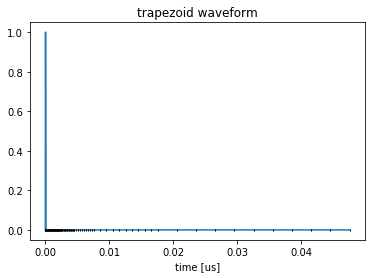

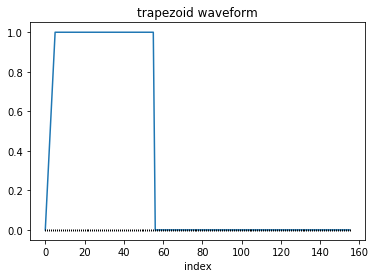

In [2]:
offTime = 5e-6 # 5 us

ramp = [
    (1e-6, 55),(5e-5, 50),(1e-4, 20),(3e-4, 10),(1e-3, 10),(3e-3, 10)
    ]
time_mesh = discretize.TensorMesh([ramp])
nt = time_mesh.nC

# define an off time past when we will simulate to keep the transmitter on
# We use a waveform with a ramp_on and ramp_off because we need to compute initial fields
trap_wave = TDEM.Src.TrapezoidWaveform(ramp_on=[0,5e-6], ramp_off=[55e-6,60e-6])

# evaluate the waveform at each time in the simulation
trap_plt = [trap_wave.eval(t) for t in time_mesh.gridN]

fig, ax = plt.subplots(1, 1)
ax.plot(time_mesh.gridN, trap_plt)
ax.plot(time_mesh.gridN, np.zeros(time_mesh.nN), 'k|', markersize=2)
ax.set_title('trapezoid waveform')
ax.set_xlabel("time [us]")

fig, ax = plt.subplots(1, 1)
ax.plot(trap_plt)
ax.plot(np.zeros(time_mesh.nN), 'k|', markersize=2)
ax.set_title('trapezoid waveform')
ax.set_xlabel("index")

### B-Field Receivers at surface

In [3]:
rx_x = np.arange(-200.,200.,5.)
rx_y = np.arange(-200.,201.,5.)
rx_z = np.array([0])
X, Y = np.meshgrid(rx_x,rx_y)

rec_list = []
rx_locs = ndgrid(rx_x, rx_y, rx_z)
for kk in ['x','y','z']:
    # Add current density receivers. Other options include _e (e-field), _b (b-field), etc.
    rec = TDEM.Rx.Point_j(locs=rx_locs, times=time_mesh.gridN, orientation=kk)
    rec_list.append(rec)
    

### Sources
Use the waveform as a source for a LineCurrent source

In [4]:
ns = 75
xs_start = -75
xs_end = 75
slope = 1.5

loc_x = np.linspace(xs_start, xs_end, ns) # x offset of transmitter loop
loc_y = (slope*loc_x) # y offset of transmitter loop
loc_z = np.zeros((ns,)) # z offset of transmitter loop
loc = np.stack((loc_x,loc_y,loc_z),axis=1)

# For the long on-time simulation. We use the ramp-on waveform
src_loop = TDEM.Src.LineCurrent(
    rxList=rec_list, loc=loc, waveform=trap_wave
)

src_list = [src_loop]


### Build a model - Sphere

In [5]:
back_sigma = 1e-4  # conductivity of the background

target_sigma = .5  # conductivity of the target
target_a = 40  # x length of target
target_b = 40  # y length of the target
target_c = 40  # z length of target
target_gamma = np.deg2rad(0) # roll
target_beta = np.deg2rad(0) # pitch
target_alpha = np.deg2rad(0) # yaw

target_x = 0 # horizontal offset of target
target_y = 0 # horizontal offset of target
target_z = 75 # vertical offset of target

### Mesh
Create the tensor mesh. Since cylindrical symmetry isn't possible, use other instead

27000


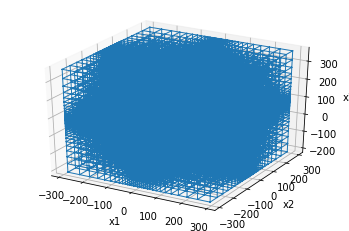

In [6]:
csx = 8 # core cell size in the x-direction
csy = 8 # core cell size in the y-direction
csz = 8 # core cell size in the z-direction
# padding parameters
npadx, npady, npadz = 10, 10, 10  # number of padding cells
pfx = 1.2  # expansion factor for the padding to infinity in the x-direction
pfy = 1.2  # expansion factor for the padding to infinity in the z-direction
pfz = 1.2 # expansion factor for the padding to infinity in the z-direction

ncx = 2*int(target_a/csx)  # number of x cells in the core region
ncy = 2*int(target_b/csy)  # number of y cells in the core region
ncz = 2*int(target_c/csz)  # number of z cells in the core region

hx = [(csx, npadx, -pfx), (csx, ncx), (csx, npadx, pfx)]
hy = [(csy, npady, -pfy), (csy, ncy), (csy, npady, pfy)]
hz = [(csz, npadz, -pfz), (csz, ncz), (csz, npadz, pfz)]
M = Mesh.TensorMesh([hx, hy, hz], x0='CCC')

# put the origin at the center of the target
M.x0 = center_mesh3d(M,target_x,target_y,target_z)

fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')
opts = {}
M.plotGrid(ax=axes, **opts)

print(M.nC)


Give the mesh some physical properties

In [7]:
sigma_model = np.ones(M.nC)*back_sigma

gridCC_rotx = (np.cos(target_alpha)*np.cos(target_beta)*(M.gridCC[:,0]-target_x)
            + (np.cos(target_alpha)*np.sin(target_beta)*np.sin(target_gamma)
            -  np.sin(target_alpha)*np.cos(target_gamma))*(M.gridCC[:,1]-target_y)
            + (np.cos(target_alpha)*np.sin(target_beta)*np.cos(target_gamma)
            +  np.sin(target_alpha)*np.sin(target_gamma))*(M.gridCC[:,2]-target_z))
gridCC_roty = (np.sin(target_alpha)*np.cos(target_beta)*(M.gridCC[:,0]-target_x)
            + (np.sin(target_alpha)*np.sin(target_beta)*np.sin(target_gamma)
            +  np.cos(target_alpha)*np.cos(target_gamma))*(M.gridCC[:,1]-target_y)
            + (np.sin(target_alpha)*np.sin(target_beta)*np.cos(target_gamma)
            -  np.cos(target_alpha)*np.sin(target_gamma))*(M.gridCC[:,2]-target_z))
gridCC_rotz = (-np.sin(target_beta)*(M.gridCC[:,0]-target_x)
            +   np.cos(target_beta)*np.sin(target_gamma)*(M.gridCC[:,1]-target_y)
            +   np.cos(target_beta)*np.cos(target_gamma)*(M.gridCC[:,2]-target_z))

# find the indices of the target
target_inds = ((gridCC_rotx)**2/target_a**2 
             + (gridCC_roty)**2/target_b**2 
             + (gridCC_rotz)**2/target_c**2 <= 1)
air_inds = M.gridCC[:,2] >= 0

#sigma_model[air_inds] = 1e-17
sigma_back = np.copy(sigma_model)
sigma_model[target_inds] = target_sigma

mu_back = np.ones(M.nC) * mu_0


Plot the model

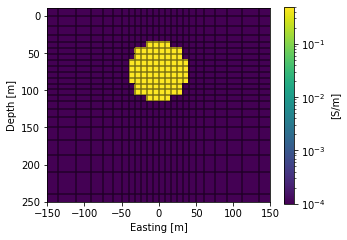

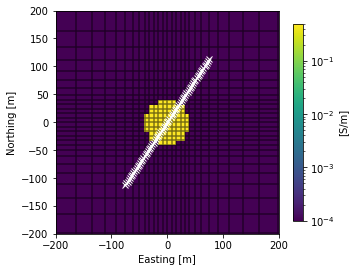

In [8]:
xlim = np.r_[-200, 200]  # x-limits in meters
zlim = np.r_[-10, 300.]  # z-limits in meters. (z-positive up)

for mod in [sigma_model]:
    fig = plt.figure(figsize=(960/192,960/192))
    ax = fig.add_subplot(111)
    # plot the permeability
    plt.colorbar(M.plotSlice(
        mod, normal='y', ax=ax, grid=True,
        pcolorOpts={'norm': LogNorm()},  # plot on a log-scale
    )[0], ax=ax, shrink=.725, aspect=20).set_label("[S/m]")
    #ax.plot(np.r_[radius_loop+radius_x], np.r_[radius_z], 'wo', markersize=8)
    #ax.plot(np.r_[-radius_loop+radius_x], np.r_[radius_z], 'wx', markersize=8)

    #ax.set_title("Conductivity [S/m]")
    ax.set_title("")
    ax.set_xlabel("Easting [m]")
    ax.set_ylabel("Depth [m]")
    ax.set_xlim([-150,150])
    ax.set_ylim([-10,250])
    #ax.axis([-200,200,-10,290])
    ax.set_aspect('equal')
    plt.gca().invert_yaxis()

    #fig.savefig('sigma_sphere.png',bbox_inches='tight', dpi=192)
    
    ################
    fig = plt.figure(figsize=(960/192,960/192))
    ax = fig.add_subplot(111)
    # plot the permeability
    plt.colorbar(M.plotSlice(
        mod, normal='z', ax=ax, grid=True,
        pcolorOpts={'norm': LogNorm()},  # plot on a log-scale
    )[0], ax=ax, shrink=.725, aspect=20).set_label("[S/m]")
    ax.plot(loc_x, loc_y,'wx')
    #ax.plot(np.r_[-radius_loop+radius_x], np.r_[radius_z], 'wx', markersize=8)

    #ax.set_title("Conductivity [S/m]")
    ax.set_title("")
    ax.set_xlabel("Easting [m]")
    ax.set_ylabel("Northing [m]")
    ax.set_xlim([-200,200])
    ax.set_ylim([-200,200])
    #ax.axis([-200,200,-10,290])
    ax.set_aspect('equal')
    #plt.gca().invert_yaxis()


### Create the Simulation
To simulate magnetic flux data, we use the b-formulation of Maxwell’s equations


In [9]:
prob = TDEM.Problem3D_b(
    mesh=M, sigmaMap=Maps.IdentityMap(M), timeSteps=ramp,
    Solver=Pardiso
)

survey = TDEM.Survey(src_list)
prob.pair(survey)


### Run the simulation!

In [10]:
t = time.time()
print('--- Running TDEM Simulation ---')

#prob.mu = mu_back
fields = prob.fields(sigma_model)

print(" ... done. Elapsed time {}".format(time.time() - t))
print('\n')

t = time.time()
print('--- Running BG TDEM Simulation ---')

#prob.mu = mu_back
fields_back = prob.fields(sigma_back)

print(" ... done. Elapsed time {}".format(time.time() - t))
print('\n')


--- Running TDEM Simulation ---
 ... done. Elapsed time 83.2741870880127


--- Running BG TDEM Simulation ---
 ... done. Elapsed time 88.39589095115662




In [11]:
# grab the last time-step in the simulation
tstep = 60
b_end = utils.mkvc(fields[:, 'b', tstep])*1e9
b_back_end = utils.mkvc(fields_back[:, 'b', tstep])*1e9
b_diff = (b_end - b_back_end)


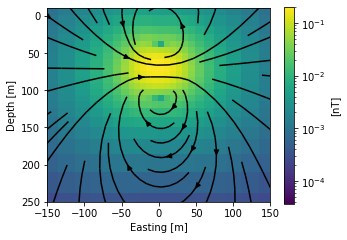

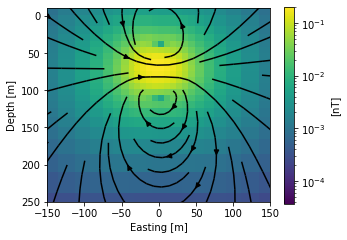

In [12]:
for d in [b_end,b_diff]:

    fig = plt.figure(figsize=(960/192,960/192))
    ax = fig.add_subplot(111)
    plt.colorbar(M.plotSlice(
        d, normal='y', ax=ax, grid=False,
        pcolorOpts={'norm': LogNorm()},
        view='vec', vType='F'# plot on a log-scale
    )[0], ax=ax, shrink=.725, aspect=20).set_label("[nT]")
    #ax.plot(np.r_[radius_loop+radius_x], np.r_[radius_z], 'wo', markersize=8)
    #ax.plot(np.r_[-radius_loop+radius_x], np.r_[radius_z], 'wx', markersize=8)

    #ax.set_title("Scattered Magnetic Field [nT]")
    ax.set_title("")
    ax.set_xlabel("Easting [m]")
    ax.set_ylabel("Depth [m]")
    ax.set_xlim([-150,150])
    ax.set_ylim([-10,250])
    #ax.axis([-200,200,-10,290])
    ax.set_aspect('equal')
    plt.gca().invert_yaxis()


### Grab data from RX

In [13]:
rxfields = survey.eval(fields) # probably takes in a fields object...?
rxback   = survey.eval(fields_back) # probably takes in a fields object...?

# ORDERING OF DATA IS (T,Y,X)
rxfields_x = rxfields[src_loop,rec_list[0]].reshape(nt+1,len(rx_y),len(rx_x))*1e9
rxfields_y = rxfields[src_loop,rec_list[1]].reshape(nt+1,len(rx_y),len(rx_x))*1e9
rxfields_z = rxfields[src_loop,rec_list[2]].reshape(nt+1,len(rx_y),len(rx_x))*1e9

rxback_x = rxback[src_loop,rec_list[0]].reshape(nt+1,len(rx_y),len(rx_x))*1e9
rxback_y = rxback[src_loop,rec_list[1]].reshape(nt+1,len(rx_y),len(rx_x))*1e9
rxback_z = rxback[src_loop,rec_list[2]].reshape(nt+1,len(rx_y),len(rx_x))*1e9

rxdiff_x = rxfields_x - rxback_x
rxdiff_y = rxfields_y - rxback_y
rxdiff_z = (rxfields_z - rxback_z)


## Plot the fields
Jz field during the on time (first figure) indicates that the wire is shielded minus the end points (where current is grounded). Other components are consistent with this. Bz is also consistent with this setup.

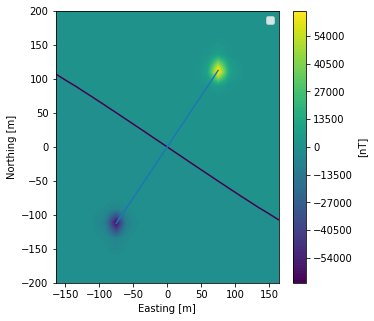

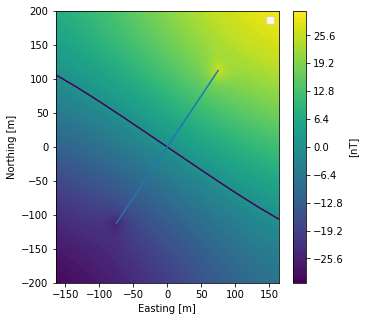

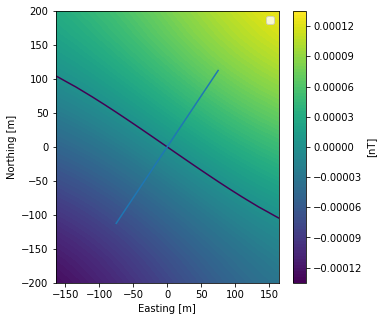

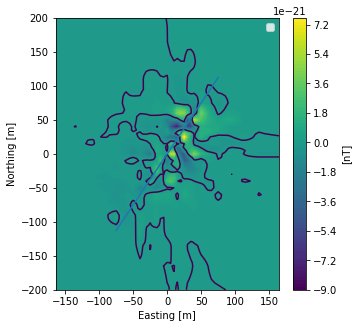

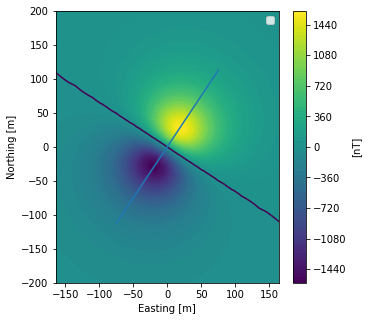

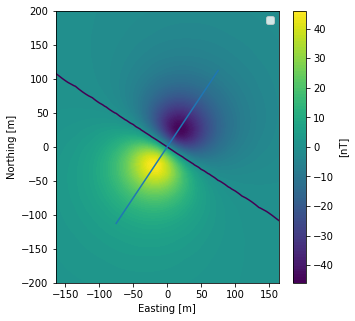

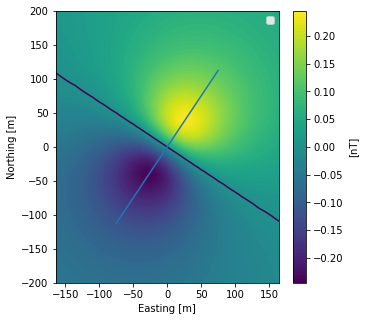

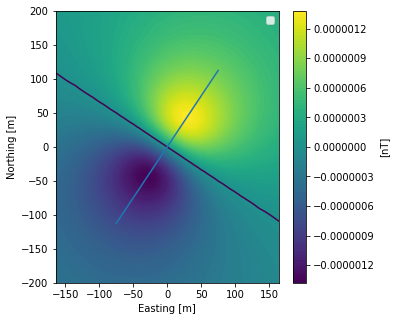

In [14]:
ptime = [55,56,60,90]
mod = [rxback_z, rxdiff_z]
hands = []

for m in mod:
    for ii in ptime:
        fig = plt.figure(figsize=(960/192,960/192))
        plt.contourf(X,Y,m[ii,:,:], 100)
        plt.colorbar().set_label("[nT]")
        plt.contour(X,Y,m[ii,:,:],levels=[0])
        plt.plot(loc_x,loc_y)
        
        #ax.axis([-200,200,-10,290])
        plt.axis('equal')
        plt.xlim([-150,150])
        plt.ylim([-200,200])
        plt.xlabel("Easting [m]")
        plt.ylabel("Northing [m]")

        plt.legend(handles=hands,loc='upper right')
